In [1]:
import os
import sys
import os.path as osp
os.chdir('../')
sys.path.append(os.path.abspath('./detection'))
sys.path.append(os.path.abspath('./tracking'))
import yaml
import numpy as np
import torch
import mmengine
import importlib
from matplotlib import pyplot as plt
from mmengine.config import Config
from mmdet3d.registry import MODELS, TRANSFORMS
from mmdet3d.utils import register_all_modules
from mmengine.runner import load_checkpoint
from mmdet3d.structures import LiDARInstance3DBoxes
from mmdet3d.structures import Box3DMode
from mot_3d.mot import MOTModel
from mot_3d.data_protos import BBox
from mot_3d.frame_data import FrameData
from trajectory_prediction.model.model import TrajectoryModel

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-2wwmow03 because the default path (/home/hello/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def data_preprocess(tracks):
    
    global config, obs_len, pred_len
    obs = []
    neis = []
    n_neighbors = []
    neis_mask = []
    refs = []
    rot_mats = []
    ids = []
    all_ids = list(tracks.keys())
    all_tracks = np.array([tracks[k] for k in all_ids])
    for i in range(len(all_tracks)):
        if all_tracks[i][-1][0] > 1e8 or all_tracks[i][-2][0] > 1e8:
            continue
        ob = all_tracks[i].copy()
        for j in range(obs_len - 2, -1, -1):
            if ob[j][0] > 1e8:
                ob[j] = ob[j+1]
        nei = all_tracks[np.arange(len(all_tracks)) != i]
        # nei = all_tracks.copy()
        dist = np.linalg.norm(ob.reshape(1, obs_len, 2) - nei, axis=-1)
        dist = np.min(dist, axis=-1)
        nei = nei[dist < config.dist_threshold]
        
        refs.append(ob[-1])
        nei = nei - ob[-1]
        ob = ob - ob[-1]
        
        angle = np.arctan2(ob[0][1], ob[0][0])
        rot_mat = np.array([[np.cos(angle), -np.sin(angle)], 
                            [np.sin(angle), np.cos(angle)]])
        ob = np.matmul(ob, rot_mat)
        for j in range(nei.shape[0]):
            # mask = nei[j][:, 0] < 1e8
            # nei[j][mask] = np.matmul(nei[j][mask], rot_mat)
            nei[j] = np.matmul(nei[j], rot_mat)
            
        obs.append(ob)
        neis.append(nei)
        n_neighbors.append(nei.shape[0])
        rot_mats.append(rot_mat)
        ids.append(all_ids[i])
    
    if len(obs) == 0:
        return None
    
    max_neighbors = max(n_neighbors)
    if max_neighbors == 0:
        max_neighbors = 1
    neis_pad = []
    for neighbor, n in zip(neis, n_neighbors):
        neis_pad.append(np.pad(neighbor, ((0, max_neighbors-n), (0, 0),  (0, 0)), "constant"))
        mask = np.zeros((max_neighbors, max_neighbors))
        mask[:n, :n] = 1
        neis_mask.append(mask)
        
    obs = torch.tensor(np.stack(obs), dtype=torch.float32).cuda()
    neis = torch.tensor(np.stack(neis_pad), dtype=torch.float32).cuda()
    neis_mask = torch.tensor(np.stack(neis_mask), dtype=torch.float32).cuda()
    refs = torch.tensor(np.stack(refs), dtype=torch.float32).cuda()
    rot_mats = torch.tensor(np.stack(rot_mats), dtype=torch.float32).cuda()
    
    return obs, neis, neis_mask, refs, rot_mats, ids


def update_tracks(tracks, update_ids, update_bboxes):
    
    global obs_len, pred_len
    is_updated = {k: False for k in tracks.keys()}
    for i in range(len(update_ids)):
        if tracks.get(update_ids[i]) is None:
            tracks[update_ids[i]] = [[1e9, 1e9]] * (obs_len - 1) + [update_bboxes[i][:2].tolist()]
        else:
            tracks[update_ids[i]].pop(0)
            tracks[update_ids[i]].append(update_bboxes[i][:2].tolist())
            # 对丢失的track进行线性插值
            lost_frame = -1
            for j in range(1, obs_len - 1):
                if tracks[update_ids[i]][j][0] > 1e8 and tracks[update_ids[i]][j-1][0] < 1e8:
                    lost_frame = j
                    break
            if lost_frame != -1:
                start = tracks[update_ids[i]][lost_frame - 1]
                end = tracks[update_ids[i]][-1]
                for j in range(lost_frame, obs_len - 1):
                    tracks[update_ids[i]][j] = [start[0] + (end[0] - start[0]) / (obs_len - lost_frame) * (j - lost_frame + 1),
                                                start[1] + (end[1] - start[1]) / (obs_len - lost_frame) * (j - lost_frame + 1)]
            is_updated[update_ids[i]] = True
            
    for k in list(tracks.keys()):
        if is_updated.get(k, True) == False:
            for j in range(obs_len - 1, 1, -1):
                if tracks[k][j][0] < 1e8:
                    tracks[k].pop(0)
                    tracks[k].append([1e9, 1e9])
                    break
            else:
                del tracks[k]

In [3]:
# load detection model
cfg = Config.fromfile('./detection/my_projects/CMT/configs/cmt_coda.py')
checkpoint = './detection/ckpts/CMT/cmt_coda.pth'
info_path = './detection/data/CODA/coda_infos_val.pkl'
register_all_modules()
detect_model = MODELS.build(cfg.model)
pipeline = []
for transform in cfg.test_dataloader.dataset.pipeline:
    pipeline.append(TRANSFORMS.build(transform))
checkpoint = load_checkpoint(detect_model, checkpoint, map_location='cpu')
detect_model.cuda().eval()

# load tracking model
config_path = './tracking/configs/coda_configs/diou.yaml'
configs = yaml.load(open(config_path, 'r'), Loader=yaml.Loader)
class_labels = [0, 1, 2]
class_names = ['car', 'pedestrian', 'cyclist']
trackers = [MOTModel(configs, class_names[label]) for label in class_labels]

config_path = './trajectory_prediction/configs/coda.py'
motion_modes_file = './trajectory_prediction/data/CODA_motion_modes.pkl'
checkpoint = './trajectory_prediction/checkpoint/CODA/coda.pth'
spec = importlib.util.spec_from_file_location('config', config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)
obs_len = config.OB_HORIZON
pred_len = config.PRED_HORIZON
motion_modes = torch.tensor(mmengine.load(motion_modes_file), dtype=torch.float32).cuda()
traj_pre_model = TrajectoryModel(in_size=2, obs_len=obs_len, pred_len=pred_len, embed_size=config.model_hidden_dim, 
        enc_num_layers=2, int_num_layers_list=[1,1], heads=4, forward_expansion=2)
traj_pre_model.load_state_dict(torch.load(checkpoint))
traj_pre_model.cuda().eval()

# load data_info
data_info = mmengine.load(info_path)
tracks = {}
count = 0

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loads checkpoint by local backend from path: ./detection/ckpts/CMT/cmt_coda.pth


In [44]:
#  load data
input = data_info['data_list'][count]
token = input['token']
timestamp = input['timestamp']
ego2global = input['ego2global']
path_prefix = info_path[:info_path.rfind('/')+1]
input['lidar_points']['lidar_path'] = path_prefix + input['lidar_points']['lidar_path']
for image in input['images'].values():
    image['img_path'] = path_prefix + image['img_path']
input['box_type_3d'] = LiDARInstance3DBoxes
input['box_mode_3d'] = Box3DMode.LIDAR

# detection
with torch.no_grad():
    for transform in pipeline:
        input = transform(input)
    input['data_samples'] = [input['data_samples']]
    input['inputs']['points'] = [input['inputs']['points']]
    input['inputs']['img'] = [input['inputs']['img']]
    output = detect_model.data_preprocessor(input, training=False)
    output = detect_model(**output, mode='predict')
    bboxes_3d = output[0].get('pred_instances_3d')['bboxes_3d']
    labels_3d = output[0].get('pred_instances_3d')['labels_3d']
    scores_3d = output[0].get('pred_instances_3d')['scores_3d']
    bboxes_3d = bboxes_3d[scores_3d > 0.3].tensor.cpu().numpy()
    labels_3d = labels_3d[scores_3d > 0.3].cpu().numpy()
    scores_3d = scores_3d[scores_3d > 0.3].cpu().numpy()

# tracking
track_labels = []
track_ids = []
track_bboxes = []
track_states = []
for i, label in enumerate(class_labels):
    mask = labels_3d == label
    dets = np.concatenate([bboxes_3d[mask], scores_3d[mask][:, None]], axis=1).tolist()
    frame_data = FrameData(dets=dets, ego=ego2global, pc=None, det_types=labels_3d[mask], time_stamp=float(timestamp))
    frame_data.dets = [BBox.bbox2world(ego2global, det) for det in frame_data.dets]
    results = trackers[i].frame_mot(frame_data)
    track_labels.append([trk[3] for trk in results])
    track_ids.append([trk[1] for trk in results])
    track_bboxes.append(np.array([BBox.bbox2array(trk[0]) for trk in results]))
    track_states.append([trk[2] for trk in results])

# trajectory prediction
track_ids = track_ids[1]
track_bboxes = track_bboxes[1]
track_states = track_states[1]
update_ids = []
update_bboxes = []
for i in range(len(track_bboxes)):
    state = track_states[i].split('_')
    if state[0] == 'birth' or (state[0] == 'alive' and int(state[1]) == 1):
        update_ids.append(track_ids[i])
        update_bboxes.append(track_bboxes[i])
update_tracks(tracks, update_ids, update_bboxes)
        
data_input = data_preprocess(tracks)
if data_input is not None:
    with torch.no_grad():
        obs, neis, neis_mask, refs, rot_mats, track_ids = data_input
        preds, scores = traj_pre_model(obs, neis, motion_modes, neis_mask, None, test=True, num_k=3)
        scores = torch.nn.functional.softmax(scores, dim=-1)
        preds = preds.reshape(preds.shape[0], preds.shape[1], pred_len, 2)
        rot_mats_T = rot_mats.transpose(1, 2)
        obs_ori = torch.matmul(obs, rot_mats_T) + refs.unsqueeze(1)
        preds_ori = torch.matmul(preds, rot_mats_T.unsqueeze(1)) + refs.unsqueeze(1).unsqueeze(2)
        obs_ori = obs_ori.cpu().numpy()
        preds_ori = preds_ori.cpu().numpy()

count += 1

(-129.55803600000002, -89.558036, 337.929127, 377.929127)

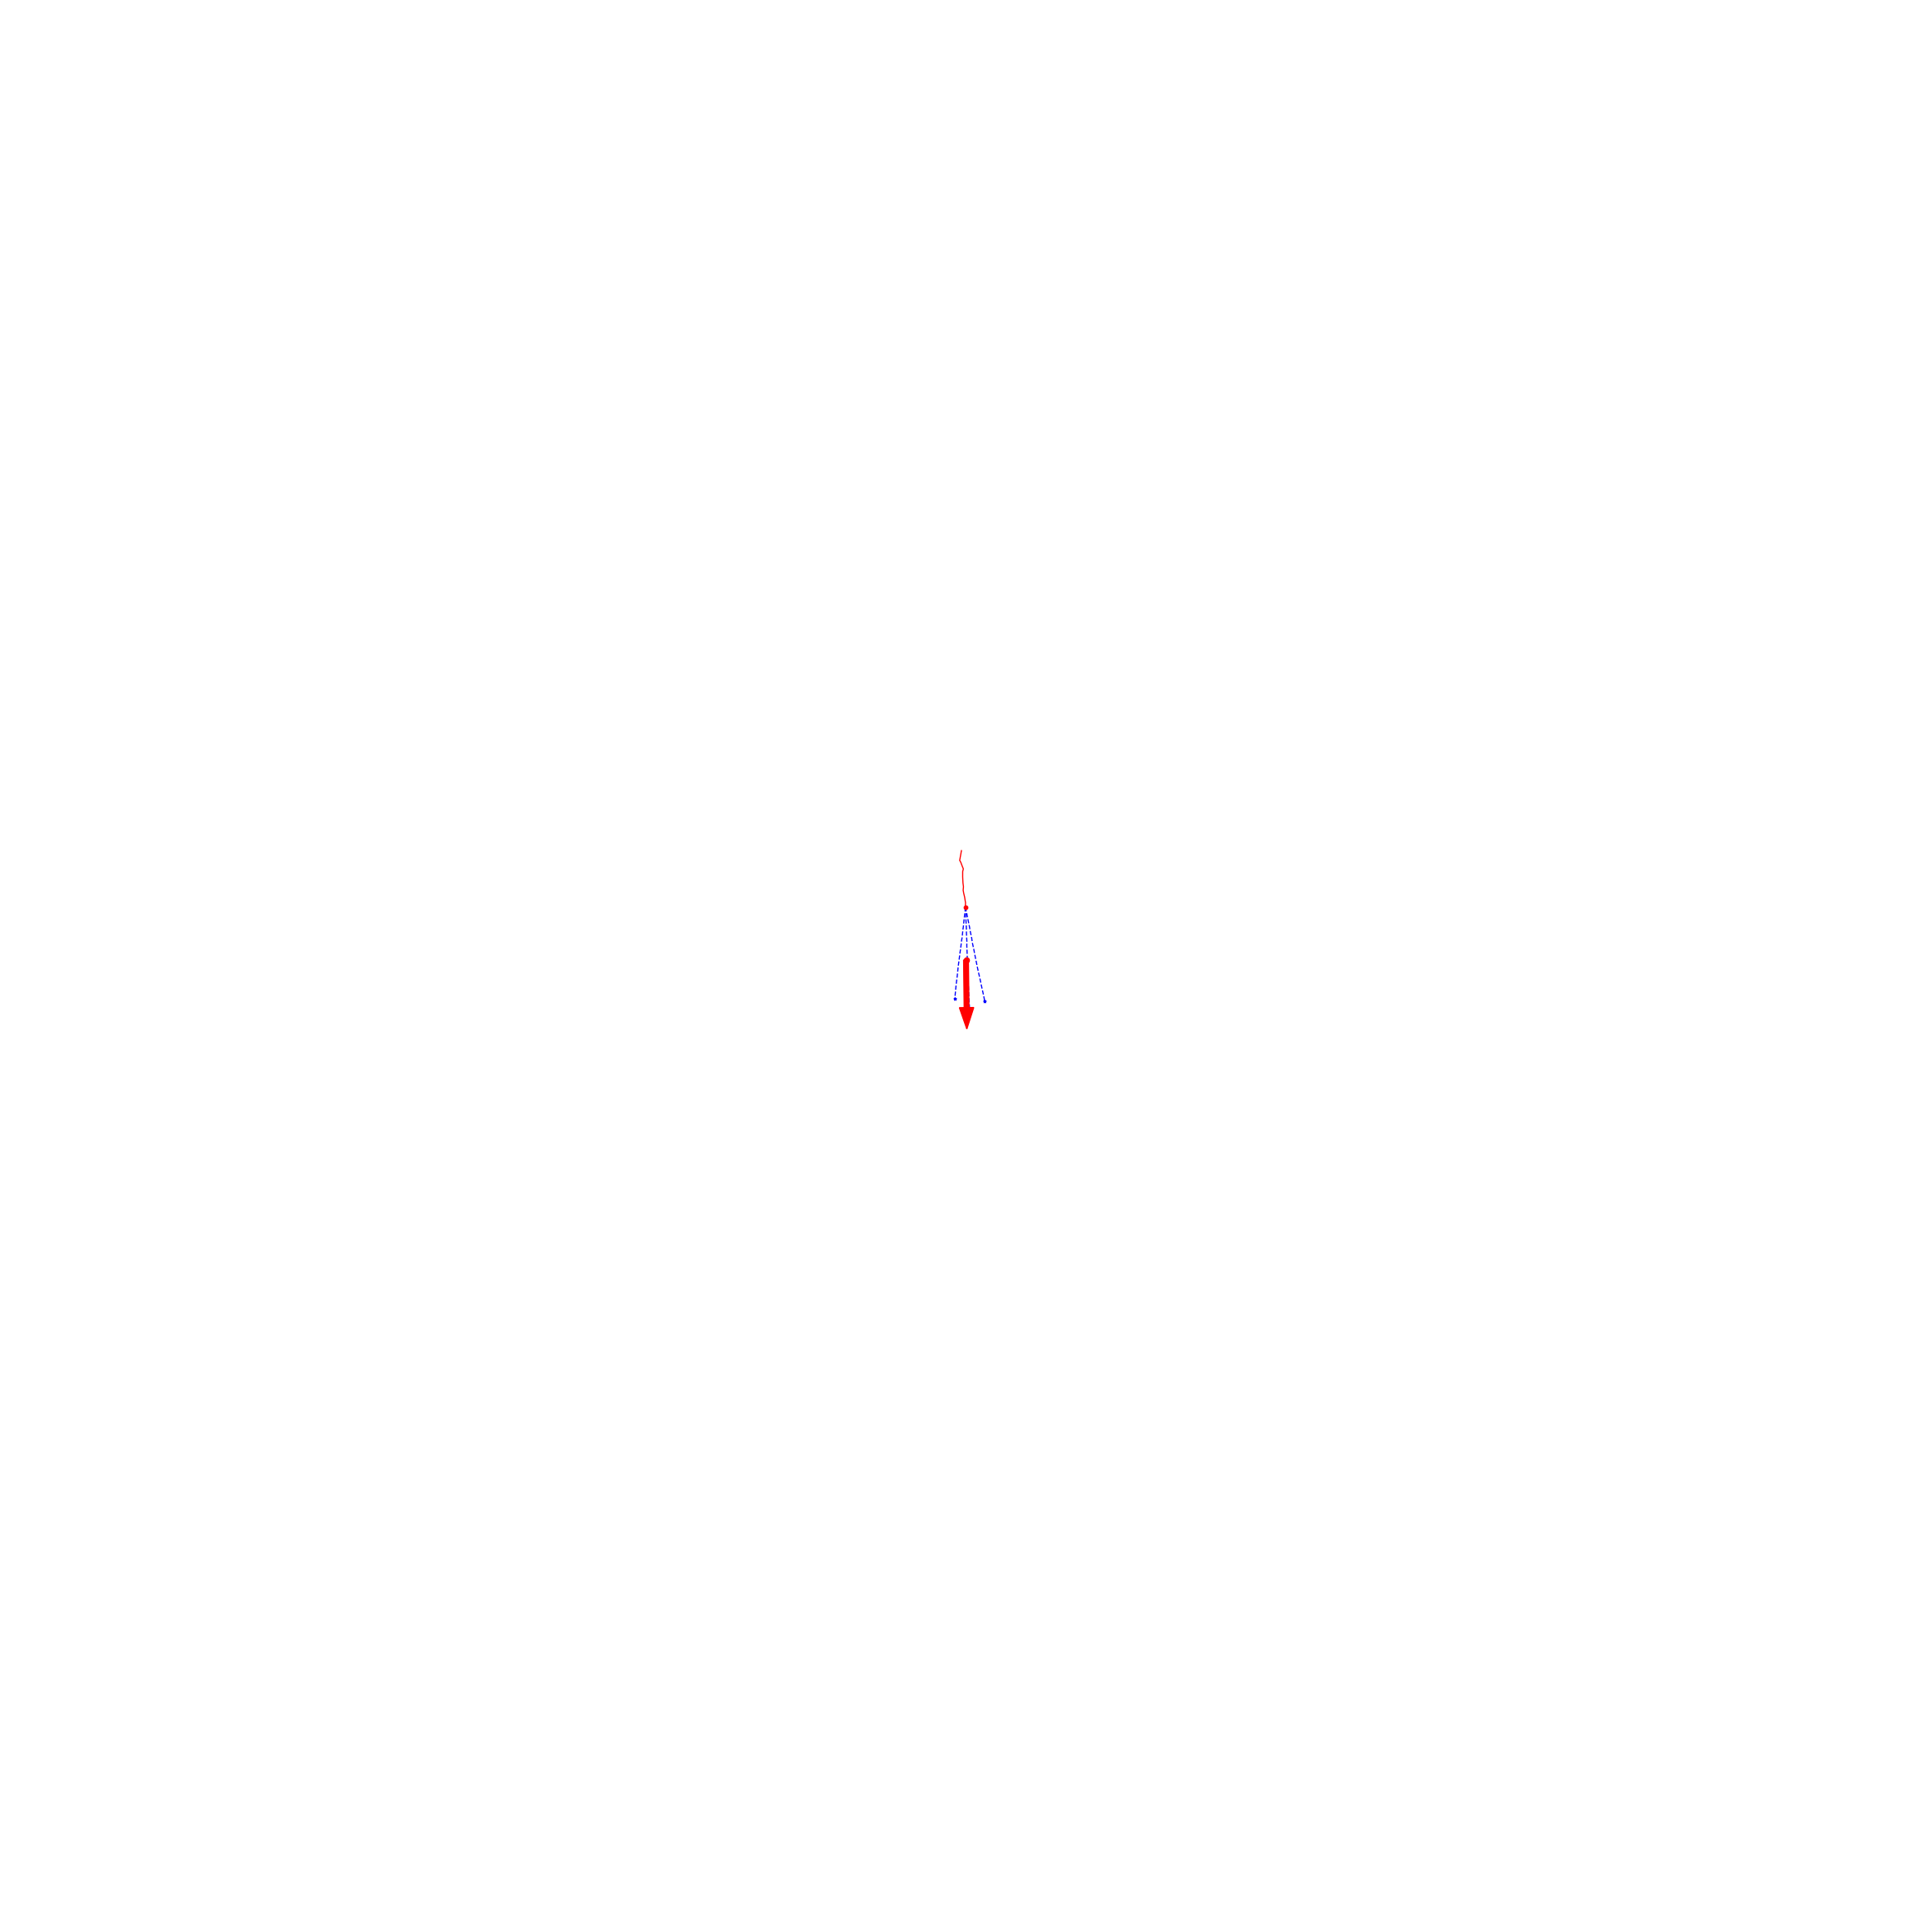

In [45]:
# visualization
pcd_range = [-20.0, 20.0, -20.0, 20.0, -0.5, 6.0]
self_pos = ego2global[:3, 3]
self_yaw = np.arctan2(ego2global[1, 0], ego2global[0, 0])
plot_range = pcd_range.copy()
plot_range[0] += self_pos[0]
plot_range[1] += self_pos[0]
plot_range[2] += self_pos[1]
plot_range[3] += self_pos[1]
plot_range[4] += self_pos[2]
plot_range[5] += self_pos[2]
plt.figure(figsize=(30, 30))
plt.xlim(plot_range[0], plot_range[1])
plt.ylim(plot_range[2], plot_range[3])
size = 0.1
# points = data_plot['points']
# plt.scatter(points[:, 0], points[:, 1], c=points[:, 2], cmap='viridis', s=size)
plt.scatter(self_pos[0], self_pos[1], c='r', s=200*size, zorder=3)
plt.arrow(self_pos[0], self_pos[1], np.cos(self_yaw), np.sin(self_yaw), color='r', width=size, zorder=2)
for i in range(obs_ori.shape[0]):
    plt.scatter(obs_ori[i, -1, 0], obs_ori[i, -1, 1], c='r', s=100*size, zorder=3)
    # plt.text(obs[i, -1, 0], obs[i, -1, 1], ids[i], fontsize=6*size, color='black', zorder=4)
    plt.plot(obs_ori[i, :, 0], obs_ori[i, :, 1], c='r', linestyle='-', linewidth=10*size, zorder=2)
    for j in range(preds_ori.shape[1]):
        pred = np.concatenate([obs_ori[i, -1].reshape(1, 2), preds_ori[i, j]], axis=0)
        plt.plot(pred[:, 0], pred[:, 1], c='b', linestyle='--', linewidth=10*size, zorder=1)
        plt.scatter(pred[-1, 0], pred[-1, 1], c='b', marker='*', s=50*size, zorder=1)
plt.axis('off')

In [8]:
obs_ori

array([[[-109.51972,  360.66113],
        [-109.51972,  360.66113],
        [-109.51972,  360.66113],
        [-109.51972,  360.66113],
        [-109.51972,  360.66113],
        [-109.51972,  360.66113],
        [-109.51972,  360.66113],
        [-109.51972,  360.66113],
        [-109.51972,  360.66113],
        [-109.51972,  360.66113],
        [-109.51972,  360.66113],
        [-109.51972,  360.66113],
        [-109.51972,  360.66113],
        [-109.51972,  360.66113],
        [-109.51972,  360.66113],
        [-109.54683,  360.53818]]], dtype=float32)

In [19]:
tracks

{0: [[1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [-109.52082313247364, 360.6602269098869],
  [-109.5469994944207, 360.5381702453895],
  [-109.58395816456705, 360.43174678669953],
  [-109.60635764454904, 360.35597154593125],
  [-109.64111064736345, 360.2959759746831],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0]],
 1: [[1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [1000000000.0, 1000000000.0],
  [-108.31953598925661, 360.67345511032306],
  [-108.28938397840903,

In [11]:
points = input['inputs']['points'][0][:, :3].cpu().numpy()

torch.Size([129559, 4])